## This notebook shortly explains how to use Quandary through the python interface.
Latest update: 11/14/2023, Stefanie Guenther (guenther5@llnl.gov)

Content:
 1. How to optimize for control pulses that realize a **unitary gate**
 2. How to **simulate** the fidelity of (optimized or prescribed) control pulses
 3. How to evaluate pulses on a specific sample rate
 4. How to get the propagator for given control parameters from Quandary?
 5. How to compare results to **QuTIP**?
 6. How to optimize for control pulses that realize a **state to state** transfer
 7. How to use the open-system solver to model decay and dephasing
 8. FAQs ("What if...")

In [1]:
#  Quandary's python interface functions are defined in /path/to/quandary/quandary.py. Import them here. 
from quandary import *
%matplotlib inline

### 1. How to optimize for control pulses that realize a **unitary gate**

Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  optimization ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy    Penalty-CtrlVar
0  9.01413770665704e-01 + 1.14880994107351e-06 + 4.92008024113254e-05 + 1.59677761749278e-06 + 1.82940089620197e-05 + 0.00000000000000e+00  Fidelity = 9.85862293342961e-02  ||Grad|| = 3.02938565436338e-01
1  4.46562869956035e-01 + 1.09663002122803e-06 + 1.53556555689983e-05 + 2.13023995821287e-06 + 2.83396267611865e-05 + 0.00000000000000e+00  Fidelity = 5.53437130043965e-01  ||Grad|| = 4.82739122708045e-01
2  1.34733999012784e-01 + 9.04952218860180e-07 + 1.56399651273920e-05 + 1.83369739152377e-06 + 2.13288288193727e-05 + 0.00000000000000e+00  Fidelity = 8.65266000987216e-01  ||Grad|| = 3.11873310564153e-01
3  4.47783395179877e-02 + 8.83120435314260e-07 + 1.35757010669867e-05 + 1.90737519871953e-06 + 2.10929666358654e-05 + 0.00000000000000e+00  Fidelity = 9.552216604820

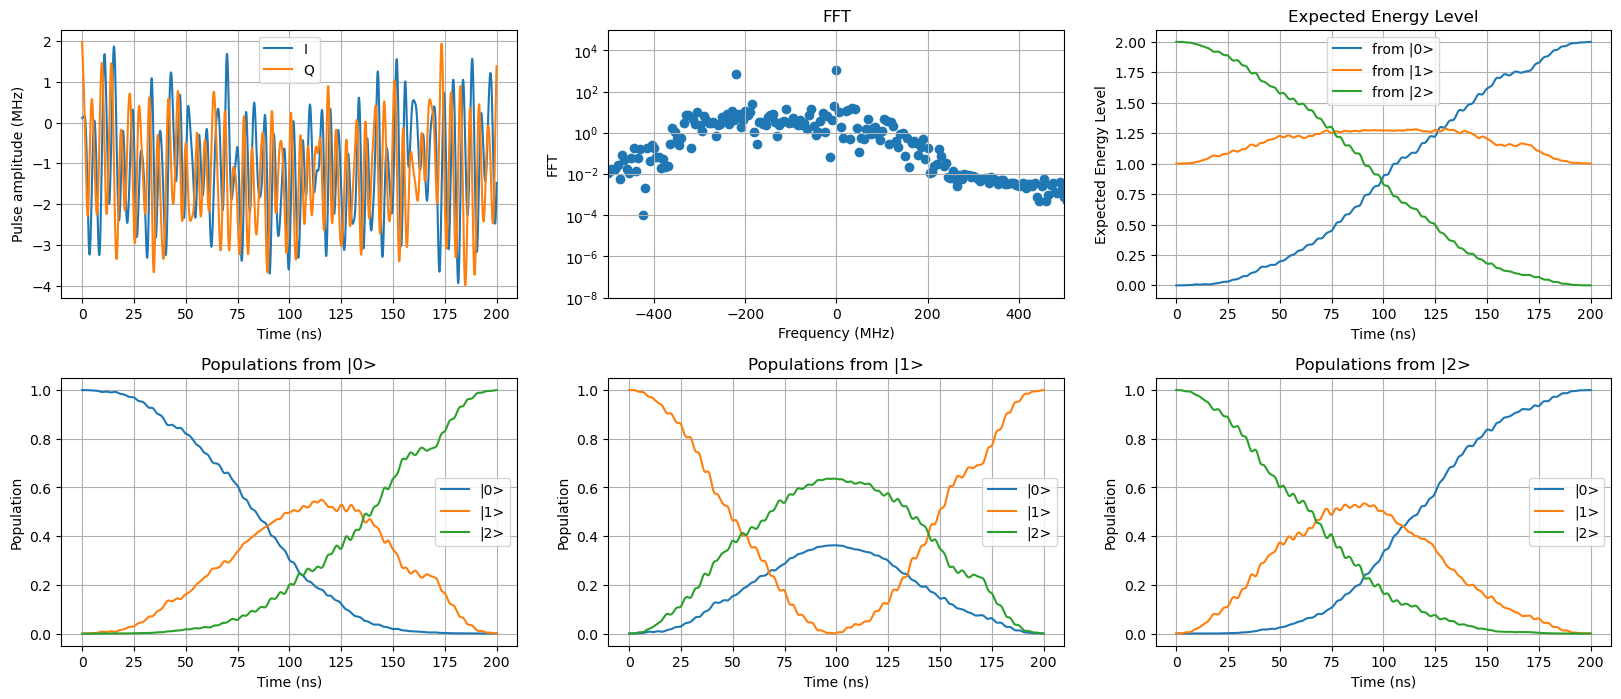


Plotting results...
-> Press <enter> to proceed.


//Users/guenther5/Numerics/quandary/quandary.py:1374: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.waitforbuttonpress(1);


In [2]:
#
# THE SHORT STORY...
# 
# Example usage of Quandary to optimize for pulses that realize a SWAP 02 gate to swap the 0-th and 2nd qubit state of a 3-level qudit.

# Define the number modelled energy levels per qubit. Here: One qudit modelled with 3 essential levels and one extra guard level
Ne = [3]   # essential levels per qubit (dimension of the target gate)
Ng = [1]   # guard levels per qubit (add a guard level to prevent leakage out of the computational subspace)

# Define the qubit frequencies [GHz]
freq01 = [4.10595]  # 0-1 transition frequency per qubit [GHz]
selfkerr = [0.2198] # anharmonicity per qubit [GHz]

# For multiple qubits, define the qubit-qubit coupling strength [GHz]
Jkl = [0.0]  # Dipole-dipole coupling strength. Format: [0<->1, 0<->2, ..., 1<->2, 1<->3, ...]

# Define the target gate. Here SWAP 02 gate to swap the 0th and 2nd energy level occupation
unitary = [[0,0,1],[0,1,0],[1,0,0]]   # Target unitary gate, here SWAP02

# Define the pulse duration
pulse_length = 200.0   # unit [ns]

# Create a Quandary object, passing the above options. Other options will be using the default values. Check 'help(Quandary)' to see all options and their defaults.
quandary = Quandary(Ne=Ne, Ng=Ng, freq01=freq01, selfkerr=selfkerr, Jkl=Jkl, targetgate=unitary, T=pulse_length, rand_seed=34525)

# Optionally: Bound the maximum control pulse amplitude per qubit, or comment out.
quandary.maxctrl_MHz = [5.0]  # [MHz]

# Optimize with Quandary. Check help(quandary.optimize) for optional arguments. This runs Quandary in the background on <prod(Ne)> cores. 
t, p, q, infidelity, expectedEnergy, population = quandary.optimize()
print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# Store the optimized Bspline parameters
popt = quandary.popt[:]

# For single-qubit systems: Plot all results in one window
plot_results_1osc(quandary, p[0], q[0], expectedEnergy[0], population[0]) 

# Other plotting functions: 
# plot_pulse(Ne, t, p, q)                       # Plot only the pulses for each qubit
# plot_expectedEnergy(Ne, time, expectedEnergy) # Plot the trajectory of the expected energy level over time
# plot_population(Ne, time, population)         # Plot the trajecotry of the qubit's level occupations over time

In [4]:
#
# THE LONG STORY...
#
# Quandary uses B-spline basis functions with carrier waves to parameterize control pulses p(t) and q(t). It solves Schroedinger's equation (or Lindblad's master equation, see below) for each initial state, and compares the solution operator to the target unitary gate. Gradient-based optimization with box-constraints is used to design pulses that realize the target gate. 

# Useful optional arguments. See help(Quandary) for a full list of all options and their default values
#   control_enforce_BC  (Bool)  : Switch whether the control pulses should start and end at zero (p(t)=0 at t=0 and t=T). Default 'False'. 
#   tol_infidelity      (Float) : Targeted accuraty of the pulses in terms of the fidelity. Default '1e-4' gives a 99.99% fidelity gate). 
#   maxiter             (Int)   : Maximum number of optimization iterations (default 100).
#   initctrl_MHz        (Float) : Amplitude of the initial guess for the pulses. Default: 1 MHz
#   randomize_init_ctrl (Bool)  : Switch whether initial control pulse should be a randomized pulse, or a constant pulse. Default: True (randomized). Only active if pcof0 is NOT given.
#   initialcondition    (String or List(float)): Decide which initial quantum states at time t=0.0 are considered. Default: "basis" (all basis states spanned in the essential dimension Ne). Or choose "pure, 0,0,1,..." for one initial state |001...>), or pass a vector as initial state (complex, essential dimensions only) 
#   pcof0               (List)  : Initial guess for the Bspline coefficients. 
#   pcof0_filename      (String): Load an initial guess from file.
#   rand_seed           (int)   : Seed for the random number generator (Default: system time, non reproducable)
#   Pmin                (Int)   : Use this many time-points to discretize one period of the solution. The higher the number, the more accurate the solution will be, and the longer the computation will take. (Default: 150)
#   verbose             (Bool)  : Flag to print more output (default: false). This is particularly useful to investigate the carrier wave frequencies that quandary selected. 

# Quandary returns:
#   t              (List)            : Time-points where the optimized control pulses are stored (ns) 
#   p, q           (List(List))      : Lists of control pulses p(t) and q(t) for each qubit, unit MHz, evaluated at each time point in t
#   infidelity     (Float)           : 1-fidelity of the realized unitary compared to the target gate
#   expectedEnergy (List(List))      : Lists of the extected energy level trajectory for each qubit evaluated at each time point in t 
#   population     (List(List(List)) : Lists of the level occupations (population) for each qubit evaluated at each time point, one list for each initial basis state, for each qubit 

# After quandary.optimize() finished, you can access
#   - quandary.popt  (list)   : List of optimized B-spline coefficients that define the optimized pulses p(t) and q(t)
#   - quandary.uT    (matrix) : The final-time quantum state for each of the propagated initial states (one column per initial state). For gate optimization (basis initial states), this is the solution operator / process matrix / propagator, see below

# If quandary.optimize() does not converge (or converges slowly), try optimizing again with 
#   a) A different seed for the random number, and/or
#   b) Increased pulse duration, and/or
#   c) Increased maximum pulse amplitude 'maxctrl_MHz'
# E.g.
# quandary.rand_seed += 1
# quandary.T = pulse_length + 10.0 # [ns]
# quandary.maxctrl_MHz = [15.0]  # [MHz]
# quandary.update() # Always call this if you changed member variables
# print(f"Re-optimizing... ")
# t, p, q, infidelity, expectedEnergy, population = quandary.optimize()
# print(f"\nOptimized Fidelity = {1.0 - infidelity}")

### 2. How to **simulate** the fidelity of (optimized or prescribed) control pulses

In [5]:
# Use the quandary.simulate(...) function to simulate the dynamics of prescribed (or previously optimized) control pulses and evalute the fidelity

# Option (a): Pass Bspline control coefficients directly. Make sure that the Quandary object is set up with the correct number of Bsplines and carrier wave frequency               
t1, p1, q1, infidelity1, _, _ = quandary.simulate(pcof0=quandary.popt[:])  # Here, I'm using the optimized parameters from the optimization above
print("Fidelity = ", 1.0 - infidelity1)

# Option: (b) Pass control pulses p(t) and q(t) directly. Make sure that the Quandary object is set up with the matching pulse duration and time-step size
t2, p2, q2, infidelity2, _, _ = quandary.simulate(pt0=p[:], qt0=q[:]) # Here, I'm using the optimized control pulses from the optimization above
print("Fidelity = ", 1.0 - infidelity2)

Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  simulation ...
Fidelity =  0.999916180161363
Executing ' mpirun -np  3 quandary ./config.cfg --quiet . Runtype:  simulation ...
Fidelity =  0.999912289800873


### 3. How to evaluate control pulses on a specific sample rate

Executing ' mpirun -np  1 quandary ./config.cfg --quiet . Runtype:  evalcontrols ...


<Figure size 640x480 with 0 Axes>

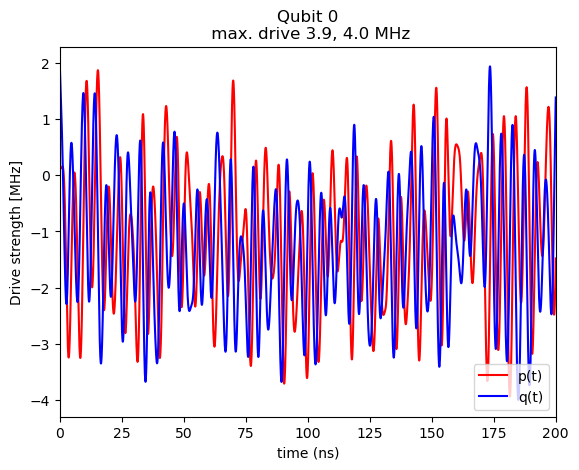


Plotting control pulses.
-> Press <enter> to proceed.


//Users/guenther5/Numerics/quandary/quandary.py:1222: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.waitforbuttonpress(1);


In [6]:
# Quandary.optimize(..) returns control pulses p(t) and q(t) that are evaluated at each time point in the list t.
# You can evaluate the pulses on a different time grid (i.e. to downsample or upsample the pulse), use the following:

# Grab the optimized Bspline coefficients:
popt = quandary.popt.copy()

# Define a sample rate (desired number of points per ns)
samplerate = 64  

# Evaluate the controls on this sample rate
t_ds, p_ds, q_ds = quandary.evalControls(pcof0=popt, points_per_ns=samplerate)

plot_pulse(Ne, t_ds, p_ds, q_ds)

# Note, p and q are lists of lists (one list for each qubit), hence accessing the first qubit's control is in p[0], e.g.
# plt.plot(t_ds, p_ds[0])  
# plt.plot(t_ds, q_ds[0])

### 4. How to get the propagator for given control parameters from Quandary

In [7]:
# After a quandary.optimize/simulate(), the field quandary.uT contains the propagated states at the final time, for each of the initial states. 
# If the initial states are the full basis (default), then this is the solution operator / process matrix / propagator. 
propagator_T = quandary.uT

# Note: If guard levels were used, then uT is rectangular matrix with one column for each initial basis state in the essential level dimension, but one row for each energy level in the full essential + guard level dimension. In the example here, uT is a 4x3 matrix
# Hopefully, the guard levels are not populated such that you can ignore the last row to extract the square (almost unitary) propagator:
propagator_3x3 = propagator_T[:-1,:]  # takes all but the last row and all columns

print("Propagator = ", propagator_3x3)

# You can also compute the fidelity from the propagator and unitary gate directly, e.g. with
nstates_ess = np.prod(quandary.Ne)
fid = np.abs(np.trace(propagator_3x3.conj().T @ unitary))**2/nstates_ess**2     
print('Pulse Fidelity = ', fid)   

Propagator =  [[-1.28130733e-03-0.00475225j -7.65933638e-04-0.00148926j
  -9.94304781e-01+0.1063895j ]
 [-5.17399639e-04+0.00323792j -9.94345417e-01+0.10590098j
   4.43076186e-04-0.00162594j]
 [-9.93543796e-01+0.11287038j  1.17023343e-03+0.00309499j
   1.86814872e-04-0.00489109j]]
Pulse Fidelity =  0.9999122897988258


### 5. How to compare results to QuTIP?

In [8]:
# Here is an example for comparing Quandary's prediction to simulation with QuTIP.
from qutip import Qobj, propagator
from qutip import QobjEvo

fidelity_quandary = np.abs(np.trace(propagator_3x3.conj().T @ unitary))**2/np.prod(quandary.Ne)**2 
print("Quandary fidelity: ", fidelity_quandary)

# QuTip requires pulses to be defined in rad/ns, so here I convert the output from quandary from MHz to rad / ns
p_radns = np.array(p[0])*1e-3*(2*np.pi)
q_radns = np.array(q[0])*1e-3*(2*np.pi)

# For some reason, QuTIP can not handle the time variable t from Quandary, so we set up a new one here...
samplerate = quandary.nsteps / quandary.T     # Sample rate of controls from Quandary
t_new = np.arange(0, len(p[0]))*1/samplerate

# Define the Hamiltonian model for QuTIP. Here, I'm taking the Hamiltonians as used in Quandary
h0 = quandary.Hsys              # System Hamiltonian
hc_re = quandary.Hc_re[0]       # Control Hamiltonian for first qubit, real part
hc_im = 1.0j*quandary.Hc_im[0]  # Control Hamiltonian for first qubit, imaginary part

# Solve Hamiltonian dynamics with Qutip
H_evo = QobjEvo([Qobj(h0), [Qobj(hc_re), p_radns], [Qobj(hc_im), q_radns]], tlist=t_new)
U_all = propagator(H_evo, t_new)

# Extract final propagator with proper dimensions
U_final = U_all[-1]
nstates = np.prod(quandary.Ne)
propagator_qutip = Qobj(U_final[:nstates, :nstates])

# Compute fidelity safely
target_unitary = Qobj(unitary)
overlap = propagator_qutip.dag() * target_unitary
fidelity_qutip = np.abs(overlap.tr())**2 / nstates**2
print('QuTIP fidelity: ', fidelity_qutip)

# Check: Both fidelities should be fairly close to each other.

Quandary fidelity:  0.9999122897988258
QuTIP fidelity:  0.9999222912697915


### 6. How to use Quandary to generate pulses that realize a **state-to-state transfer**

Executing ' mpirun -np  1 quandary ./config.cfg --quiet . Runtype:  optimization ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy    Penalty-CtrlVar
0  5.02049583478701e-01 + 2.56090704561570e-10 + 0.00000000000000e+00 + 9.01784421151395e-15 + 8.98449028423572e-09 + 0.00000000000000e+00  Fidelity = 4.97950416521299e-01  ||Grad|| = 1.33055979431340e-01
1  4.62265425914091e-02 + 1.73742095334636e-07 + 0.00000000000000e+00 + 1.24752998393009e-09 + 1.00933850676236e-05 + 0.00000000000000e+00  Fidelity = 9.53773457408591e-01  ||Grad|| = 3.24748385751329e-01
2  6.43219251352212e-03 + 8.61543734506834e-08 + 0.00000000000000e+00 + 5.68192565246782e-10 + 5.00304152044488e-06 + 0.00000000000000e+00  Fidelity = 9.93567807486478e-01  ||Grad|| = 9.69025583835661e-02
3  3.35556900665779e-06 + 1.07258277186620e-07 + 0.00000000000000e+00 + 7.57406598781309e-10 + 6.22957666424030e-06 + 0.00000000000000e+00  Fidelity = 9.999966444309

<Figure size 640x480 with 0 Axes>

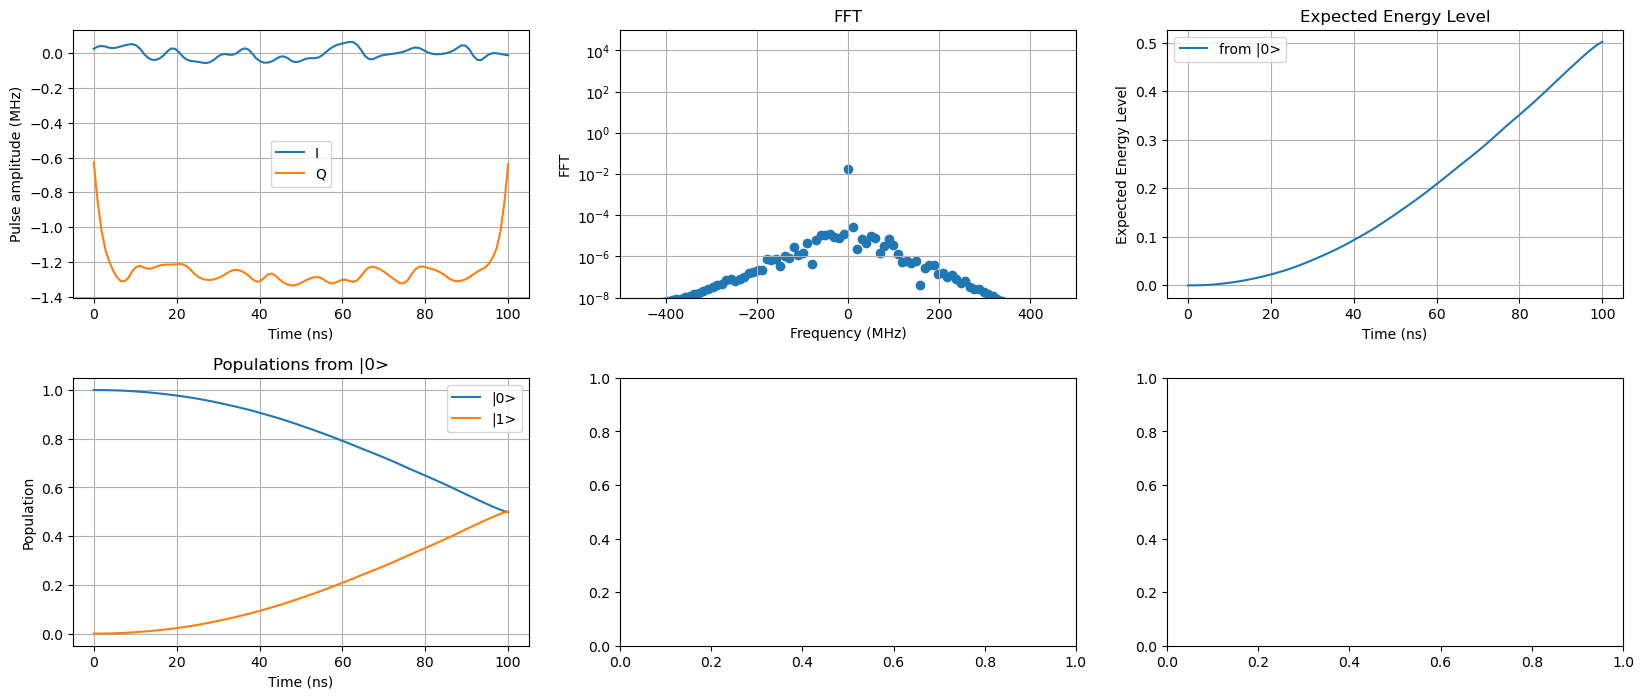


Plotting results...
-> Press <enter> to proceed.


//Users/guenther5/Numerics/quandary/quandary.py:1374: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.waitforbuttonpress(1);


Executing ' mpirun -np  2 quandary ./config.cfg --quiet . Runtype:  simulation ...
Test fidelity =  0.9999983222139354


In [9]:
# Example how to use Quandary to optimize a state-to-state transfer 

# Define the number of essential state and guard levels. This example considers a 2-level qubit with no extra guard level.
Ne = [2]    # Number of essential states per qubit 
Ng = [0]    # Number of extra guard level to prevent leakage out of the computational subspce

# Define the target and the initial state (in the essential level dimensions)
initialcondition = [1.0, 0.0]
targetstate =  [1.0/np.sqrt(2), 1.0/np.sqrt(2)]   

# Pulse length
T = 100.0

# Optionally: Define desired accuraty of the pulse in terms of the infidelity. 
tol_infidelity = 1e-5

# Optionally: Set the initial control pulse amplitude. Default is 10MHz, leading to larger controls than neccessary here, so we decrease it here.
initctrl_MHz=0.1

# Optionally: Set maximum amplitude bound [MHz]
maxctrl_MHz = 5.0

# Pass all options to the Quandary configuration
quandary = Quandary(Ne=Ne, Ng=Ng, T=T, targetstate=targetstate, initialcondition=initialcondition, tol_infidelity=tol_infidelity, initctrl_MHz=initctrl_MHz, maxctrl_MHz=maxctrl_MHz, rand_seed=1234)

# Execute quandary. Runs in the background on one core. 
t, pt, qt, infidelity, expectedEnergy, population = quandary.optimize() 
print(f"\nFidelity = {1.0 - infidelity}")

# Plot the control pulse and expected energy level evolution.
plot_results_1osc(quandary, pt[0], qt[0], expectedEnergy[0], population[0])

# Note: In contrast to gate optimization (passing targetgate=unitary), the state-to-state transfer (targetstate=...) propagates only ONE initial state through the time domain, not the entire basis of initial states. 
# After optimization, the final state stored in quandary.uT hence consists only of ONE column:
realized_state= quandary.uT.copy()
# To compute the process matrix (the propagator for this state-to-state transfer (the solution matrix / unitary that maps the initial to the target state), simulate the dynamics for the basis of initial states, using the optimized pulses,  e.g. by doing so:
quandary.initialcondition = "basis"
quandary.update()   # call update() after you have changed quandary member variables directly
t, pt, qt, _, _, _ = quandary.simulate(pcof0=quandary.popt, datadir="./test")
propagator = quandary.uT.copy()

# TEST the fidelity: Check whether the propagator uT indeed maps the initial [1,0] state to the desired target state:
test_fid = np.abs(np.array(targetstate).conj() @ propagator @ initialcondition)   # Overlap between target state and evolved state
print("Test fidelity = ", test_fid)

### 7. How to use the open-system solver to model decay and dephasing

Executing ' mpirun -np  1 quandary ./config.cfg --quiet . Runtype:  optimization ...
    Objective             Tikhonov                Penalty-Leakage        Penalty-StateVar       Penalty-TotalEnergy    Penalty-CtrlVar
0  5.04302153193254e-01 + 2.10627618973362e-10 + 7.68884448559118e-13 + 1.30073858299733e-14 + 6.26929913180880e-09 + 0.00000000000000e+00  Fidelity = 4.95697846806746e-01  ||Grad|| = 1.06633467203195e-01
1  4.72015038447107e-02 + 1.74549639007923e-07 + 2.92029258595263e-06 + 1.65120445024727e-09 + 1.01403330272047e-05 + 0.00000000000000e+00  Fidelity = 9.52798496155289e-01  ||Grad|| = 2.87426078195549e-01
2  6.62533406187116e-03 + 8.58585448540212e-08 + 7.81392051010818e-07 + 8.04178467209846e-10 + 4.98513325515569e-06 + 0.00000000000000e+00  Fidelity = 9.93374665938129e-01  ||Grad|| = 7.44287957959761e-02
3  1.48898185361457e-05 + 1.07258244109532e-07 + 1.19054377578463e-06 + 1.06171270481068e-09 + 6.22907730287354e-06 + 0.00000000000000e+00  Fidelity = 9.999851101814

<Figure size 640x480 with 0 Axes>

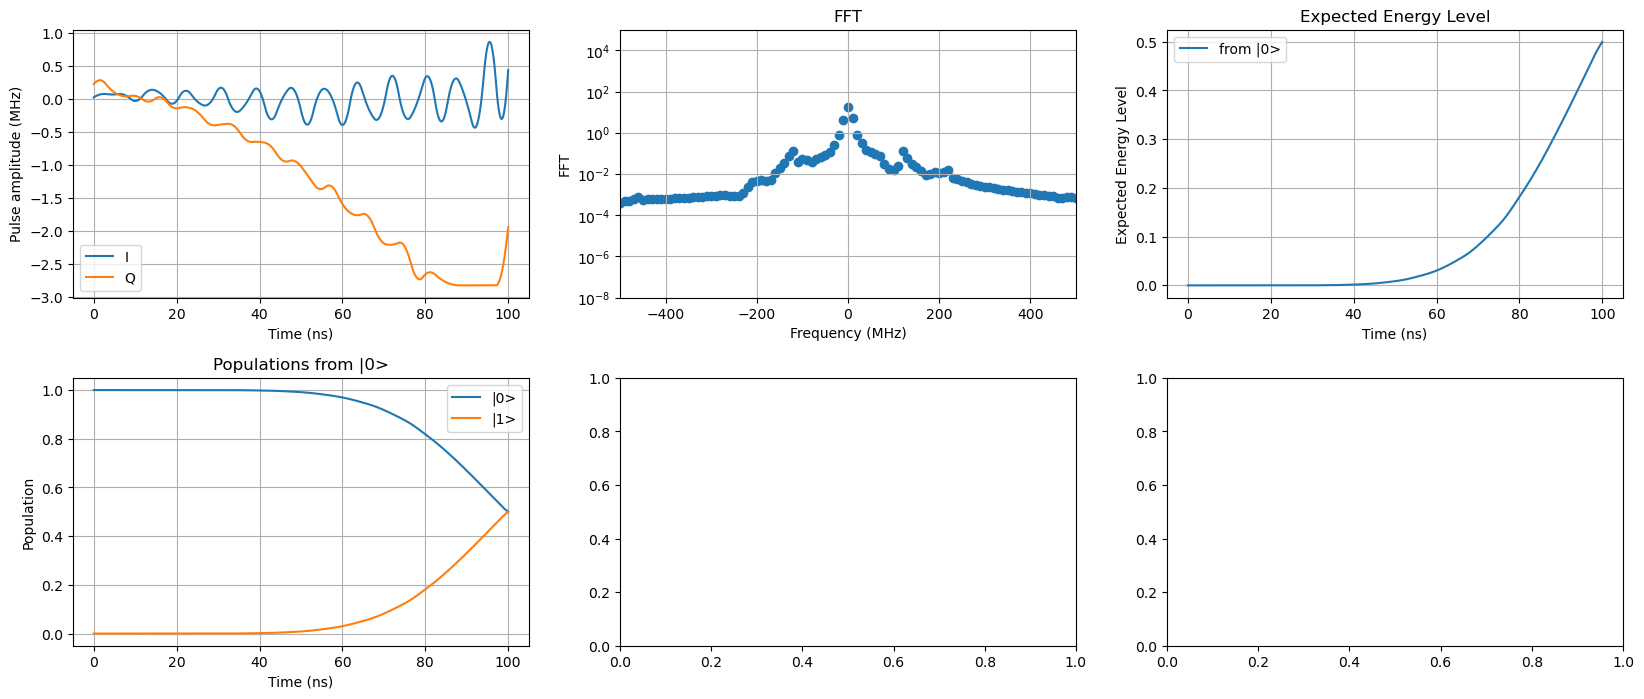


Plotting results...
-> Press <enter> to proceed.


In [10]:
# You can simulate the dynamics under Lindbladian noise operators in Quandary (for decay and dephasing noise).
# To do so, the only thing to change is to pass the decay and dephasing times to the quandary configuration. All other options and runtypes are the same. 
# Note that the Lindblad solver is computationally more expensive, especially for gate optimization. It might be good to pre-optimize on the closed system first and use the optimized parameters as initial guess for the Lindblad solver.
# Here is an example for the state-to-state transfer problem

# State-to-state transfer configuration
Ne = [2]    # Number of essential states
Ng = [1]
targetstate  =  [1.0/np.sqrt(2), 1.0/np.sqrt(2)]   # target state
initialstate = [1.0, 0.0]      # initial ground state
T = 100.0                      # pulse length
tol_infidelity = 1e-5          # Infidelity tolerance
maxiter = 50                   # Maximum number of iterations

maxctrl_MHz = 4.0              # Maximum allowed control pulse amplitude [MHz]
initctrl_MHz = 0.1             # Initial guess for control pulse amplitude [MHz]

T1 = [100000.0]  # T1 decay time [ns]
T2 = [80000.0]   # T2 dephasing time [ns]
quandary_lblad = Quandary(Ne=Ne, Ng=Ng, T=T, T1=T1, T2=T2, targetstate=targetstate, initialcondition=initialstate, maxctrl_MHz=maxctrl_MHz, initctrl_MHz=initctrl_MHz, maxiter=maxiter)

# Create and pre-optimize on the closed-system solver:
quandary_closed = quandary_lblad.copy()
quandary_closed.T1=[]   # disable T1 and T2, don't forget to update() quandary
quandary_closed.T2=[]
quandary_closed.update()
t, pt, qt, infidelity, expectedEnergy, population = quandary_closed.optimize() 
print(f"\nOptimized Fidelity = {1.0 - infidelity}")

# Evaluate the optimized pulses using the open system solver:
t, pt, qt, infidelity, expectedEnergy, population = quandary_lblad.simulate(pcof0=quandary_closed.popt) 
print(f"\nFidelity under noise = {1.0 - infidelity}")

# Further optimize on the lindblad solver
t, pt, qt, infidelity, expectedEnergy, population = quandary_lblad.optimize(pcof0=quandary_closed.popt) 
print(f"\nRe-optimized Fidelity under noise = {1.0 - infidelity}")

# # Plot the control pulse and expected energy level evolution.
plot_results_1osc(quandary_lblad, pt[0], qt[0], expectedEnergy[0], population[0])

In [20]:
# ## FAQs

# * What to do if the optimizer does not converge?
#     - Run again with a different initial guess (rand_seed=<different integer>, randomize_ctrl_init=True/False, initctrl_MHz=<double>)
#     - Remove or increase the control bounds (maxctrl_MHz=<larger double or list>)
#     - Increase the time domain (T)
#     - Set 'verbose=True' when constructing the Quandary object. Inspect the output, in particular the selected carrier wave frequencies. Do they make sense for your target gate?
#     - Increase the number of iterations (maxiter)
#     - Increase the number of Bspline basis functions (increase nsplines, or decrease spline_knot_spacing)
#     - Inspect the files written to './run_dir/' (or the user-defined alternative output directory). In particular config.cfg, targetgate/state.dat.

# * What to do if the results don't match to other software, or to my expectations?
#     - Turn on 'verbose=True' and check screen output of quandary.simulate(). Anything suspicious?
#     - Test if the time-step size is small enough (aka if "Pmin" is large enough):
#         * Simulate the pulses again with smaller Pmin and compare the uT or fidelity. If the fidelity differs significantly, time-step size should be decreased further (by using a larger "Pmin"). Have a look at the 'timestep_richardson_est' function in quandary.py, which might be helpful to do this test.  
#     - Check if the correct pulses are used (e.g. by plotting the returned p and q after "simulation" runs as well as after calling 'evalControl(..)')

# Any time: Please reach out to guenther5@llnl.gov if you have any questions, concerns, or if you found a bug.  